In [1]:
import os
import io
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

from tqdm import tqdm
from konlpy.tag import Mecab

# 1. Data load

> 본 1장에서는 실습에 활용할 데이터를 메모리에 할당 후 하나의 데이터셋으로 통합하는 과정을 기술한다.

In [2]:
def load_dataset(file_name):
    data_set = None
    with open('./Data/lecture8/'+file_name, 'r') as f:
        data_set = f.read().splitlines()
        
    return data_set     

> KR-EN 번역기에 활용할 국문 데이터와 영문 데이터를 <code>load_dataset()</code> 함수로 불러온다.

In [3]:
english_data = load_dataset('korean-english-park.train.en')
krean_data = load_dataset('korean-english-park.train.ko')

> 불러온 영문 데이터와 국문 데이터의 내용이 한 쌍으로 구성되어있는지 확인하는 작업을 진행한다.

In [4]:
print(english_data[:3])
print('\n', krean_data[:3])

['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk."]

 ['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']


> 국문, 영문 데이터가 한 쌍으로 구성되어있으므로 편의성을 위해 하나의 시트(sheet)로 통합한다.

In [5]:
kr_en_dataset = pd.DataFrame(zip(english_data, krean_data), columns=['en', 'kr'])

In [6]:
kr_en_dataset[:5]

,en,kr
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


> 위 결과로 국문, 영문 데이터가 한 시트(sheet)에 통합되었음을 확인할 수 있다.

# 2. Data Analysis

> 본 2 장에서는 국문-영문 번역기 모델에 활용할 데이터를 분석하는 과정을 기술한다.<br>
> 데이터 분석 과정은 데이터 정보 확인, 결측치 확인, 중복 데이터 확인, 문장 길이 분포 확인 작업이 진행된다.<br>

## 2.1 Check Dataset Info

> <code>pandas.DataFrame.info()</code>을 활용하여 국문-영문 통합 데이터셋인 <code>kr_en_dataset</code>의 구성 정보를 확인한다.

In [7]:
kr_en_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   en      94123 non-null  object
 1   kr      94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


> 국문과 영문 모두 94,123개의 index를 가지고 있으며, 결측치는 Null(0), 관측되지 않았다.

## 2.2 Check Dataset Deduplication

> <code>kr_en_dataset</code>에 중복되는 데이터가 없도록 중복을 제거하는 작업을 진행한다.

In [8]:
kr_en_dataset.drop_duplicates(["en"], inplace=True)
kr_en_dataset.drop_duplicates(["kr"], inplace=True)

In [9]:
kr_en_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74786 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   en      74786 non-null  object
 1   kr      74786 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


> 중복 데이터를 제거한 <code>kr_en_dataset</code>의 데이터는 기존 94,123 개에서 74,786 개로 감소되며, 19,337개의 중복 데이터가 제거되었음을 확인할 수 있다.

## 2.3 Check Sentence Length

> 국문과 영문 문장 속 단어의 개수 정보를 확인하는 함수를 구현하고, 이를 확인하는 작업을 진행한다.

In [10]:
def view_sentence_length_distribution(df_data, graph_title):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in df_data:
        length = len(sen.split())
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length

    print(graph_title,"문장 속 단어 최소 개수:", min_len)
    print(graph_title,"문장 속 단어 최대 개수:", max_len)
    print(graph_title,"문장 속 단어 평균 개수:", sum_len // len(df_data))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in df_data:
        sentence_length[len(sen.split())-1] += 1
    
    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title(graph_title+"Sentence Length Distribution")
    plt.show()

> <code>view_sentence_length_distribution()</code>를 활용하여 국문과 영문 문장 속 데이터의 개수를 확인한다.

English  문장 속 단어 최소 개수: 1
English  문장 속 단어 최대 개수: 90
English  문장 속 단어 평균 개수: 22


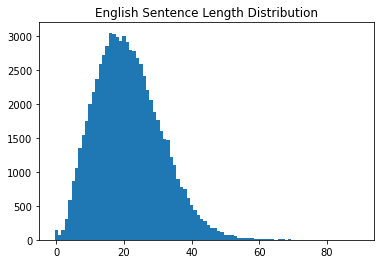

Krean  문장 속 단어 최소 개수: 1
Krean  문장 속 단어 최대 개수: 82
Krean  문장 속 단어 평균 개수: 15


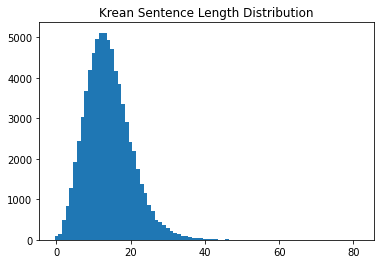

In [11]:
view_sentence_length_distribution(kr_en_dataset['en'],"English ")
view_sentence_length_distribution(kr_en_dataset['kr'],"Krean ")

> 영문 속 단어의 평균 개수는 22개이며, 0 ~ 50의 범위로 보았을 때 정규 분포의 형태를 확인할 수 있다.<br>
> 국문 속 단어의 평균 개수는 15개이며, 0 ~ 40의 범위로 보았을 때 정규 분포의 형태를 확인할 수 있다.

# 3. Data preprocessing

> 2장에서 진행한 데이터 분석 결과를 바탕으로 데이터를 전처리하는 과정을 진행한다.
> 데이터 전처리는 모델에 사용할 데이터 범위 규정, 정규식을 활용한 문장 정제, 문장 토큰화 작업을 진행한다.

## 3.1 문장 데이터 범위 규정

> 단어의 개수가 너무 적으면 노이즈가 될 수 있으므로, 단어의 개수가 너무 많으면 모델의 복잡도(연산량)이/가 비효율적으로 증가하므로 각 국-영문 데이터의 분포에 맞춰 적절한 개수로 범위를 제한하는 작업을 진행한다.

In [12]:
def sentence_lenght_limit(df_data, sentence_max, colume):
    temp_df = df_data.copy()
    temp_df["count"] = temp_df[colume].apply(lambda x: len(x.split()))
    temp_df = temp_df.loc[temp_df["count"] <= sentence_max]
    temp_df.drop(["count"], axis="columns", inplace=True)
    
    return temp_df

> 국문 데이터는 문장 속 단어 개수가 40개 초과, 영문 데이터는 60개가 초과되는 문장을 제거한다.

In [13]:
kr_en_dataset = sentence_lenght_limit(kr_en_dataset, 60, 'en')
kr_en_dataset = sentence_lenght_limit(kr_en_dataset, 40, 'kr')

In [14]:
kr_en_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74597 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   en      74597 non-null  object
 1   kr      74597 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


> 단어 개수 범위 조건 내에 해당하는 <code>kr_en_dataset</code> 문장 개수는 기존 74,786 개에서 189 개가 감소한 74,597 개이다.

## 3.2 정규식을 활용한 문장 정제

> 모델이 자연어를 학습함에 있어서 특수문자는 불필요한 노이즈로 작용하므로, 특수 문자와 국문-영문에 해당하지 않는 문자를 제거 후 공백으로 처리한다.<br>
> Decoder에 해당하는 영문에는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하므로, 문장 생성 및 종료 토큰을 추가하는 과정을 추가한다. 

In [15]:
def preprocess_sentence(sentence, decoder=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    if decoder:
        sentence = '<start> ' + sentence + ' <end>'   

    return sentence

In [16]:
kr_en_dataset['en'] = kr_en_dataset['en'].apply(lambda x: preprocess_sentence(x, decoder=True))
kr_en_dataset['kr'] = kr_en_dataset['kr'].apply(lambda x: preprocess_sentence(x, decoder=False))

In [17]:
kr_en_dataset[:5]

,en,kr
0,<start> much of personal computing is about ca...,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
1,<start> so a mention a few weeks ago about a r...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"<start> like all optical mice , but it also do...",그러나 이것은 또한 책상도 필요로 하지 않는다 .
3,<start> uses gyroscopic sensors to control the...,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어..."
4,<start> intelligence officials have revealed a...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...


## 3.3 문장 토큰화

> 국문-영문 번역기 모델에 활용할 데이터를 토큰화하는 함수를 구현 및 토큰화를 진행한다.<br>
> Encoder에 사용되는 국문 데이터에는 KoNLPy의 형태소 기반 토큰화 함수 <code>mecab()</code>으로 토큰화를 진행한다.

In [18]:
def tokenize(corpus, encoder=False):
    df_data = corpus
    
    # 데이터가 한국어일때, 형태소 기반 토큰화
    if encoder:
        mecab_o = Mecab()
        df_data = []
    
        for sentence in corpus:
            df_data.append(mecab_o.morphs(sentence))
            
    # 데이터가 한국어가 아닐때, 공백 기반 토큰화        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(df_data)

    
    tensor = tokenizer.texts_to_sequences(df_data)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [19]:
enc_tensor, enc_tokenizer = tokenize(kr_en_dataset['kr'], encoder=True)
dec_tensor, dec_tokenizer = tokenize(kr_en_dataset['en'], encoder=False)

In [20]:
print("국문 단어장 크기:", len(enc_tokenizer.index_word))
print("영문 단어장 크기:", len(dec_tokenizer.index_word))

국문 단어장 크기: 50985
영문 단어장 크기: 46128


> 국문 데이터는 토큰화 작업 이후, 50,985개의 토큰이 생성되었고, 영문 데이터는 46,128개의 토큰이 생성되었다.

# 4. Model design

> 본 실습의 국문-영문 번역기 모델은 Bahdanau 기반 Attention 모델이다.<br>
> Bahdanau Attention 모델은 아래 그림처럼 각각 1개의 GRU을 갖는 Encoder-Decoder 구조로 이루어져 있다.

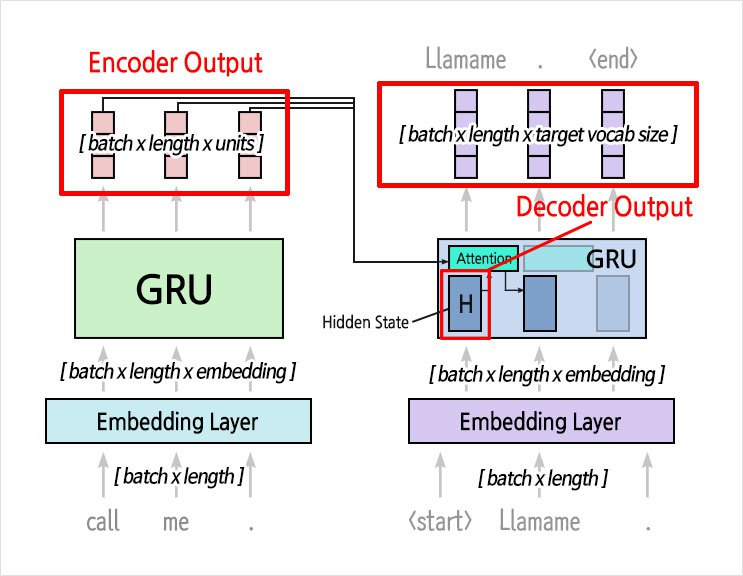

## 4.1 Bahdanau Attention

> 기존 seq2seq 기반 Encoder-Decoder 모델의 경우 문장 임베딩을 인코더에서 지정한 고정된 길이 벡터로 디코더가 예측 결과를 고정된 길이의 벡터로 압축하면서 정보손실 발생하는 문제점이 있다.<br>

> Attention은 위 문제를 encoder의 매 time step으로부터 하나씩 벡터을 추출하고, 예측할 단어와 연관이 큰 단어에 더 가중치를 부여하는 방법으로 개선했다.

> Bahdanau Attention은 다음과 같은 연산 과정으로 다중 분류 이후 각 인코더의 어텐션 가중치와 은닉 상태값을 AND 연산하여 예측률을 높이고자 고안된 Attention 기법이다.<br>
> <br>
> 1. 어텐션 스코어(Attention Score)를 구한다.<br>
> 2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.<br>
> 3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.<br>
> 4. 컨텍스트 벡터로부터 디코더의 은닉 상태값를 구한다.<br>

> 상세 내용은 아래 링크를 참고하였다.<br>
>
> [Bahdanau Attention](https://wikidocs.net/73161)

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

## 4.2 Encoder for Bahdanau Attention

> Time-Step의 Hidden State를 출력하도록 Encoder 함수를 구성한다

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

## 4.3 Decoder for Bahdanau Attention

> Encoder의 출력과 Decoder의 (t-1)Step의 은닉 상태로 Attention을 취하여 (t)Step의 은닉 상태를 생성하도록 Decoder 함수를 구현한다

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

> 256개의 유닛과 256 임베팅 차원으로 Encoder, Decoder 인스턴스 객체를 생성한다.

In [24]:
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

BATCH_SIZE     = 128
units         = 256
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

## 4.4 Optimizer and loss function

> 모델 학습을 위한 Adam 옵티마이저 객체와 손실 함수 객체를 생성한다.

In [25]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# 5. Model train

In [27]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [30]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch  1:  17%|█▋        | 198/1166 [04:15<20:50,  1.29s/it, Loss 2.6251] 


KeyboardInterrupt: 

# 6. Result

# 평가 문항

> 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.<br>
> 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.<br>
> <br>
> 2. Attentional Seq2seq 모델이 정상적으로 구동된다.<br>
> seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.<br>
> <br>
> 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.<br>
> 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.